In [1]:
!pip install 'qiskit[visualization]'
!pip install qiskit_optimization
!pip install qiskit-terra

-modules/lib/python3.7/site-packages (from h5py<3.3.0->qiskit-aqua==0.9.5->qiskit[visualization]) (1.5.2)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from time import time
from pprint import pprint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output

In [3]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit_optimization import QuadraticProgram
from docplex.mp.model import Model

In [4]:
from qiskit.optimization.applications.ising import stable_set
from qiskit import Aer
from qiskit.optimization.applications.ising import stable_set
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

/workspace/.pip-modules/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/workspace/.pip-modules/lib/python3.7/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [10]:
import dimod

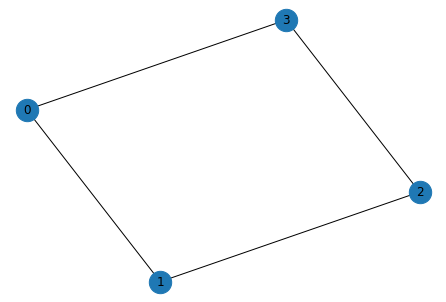

In [14]:
G1 = nx.Graph()
G1_nodes_list = [0,1,2,3]
G1_edges_list = [(0,1), (1,2), (2,3), (3,0)]
G1.add_nodes_from(G1_nodes_list)
G1.add_edges_from(G1_edges_list)
nx.draw(G1, with_labels=True, alpha=1, node_size=500)

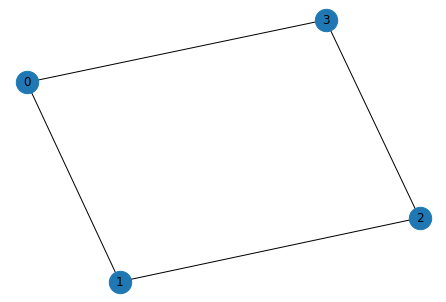

In [15]:
G2 = nx.Graph()
G2_nodes_list = [0,1,2,3]
G2_edges_list = [(0,1), (1,2), (2,3), (3,0)]
G2.add_nodes_from(G2_nodes_list)
G2.add_edges_from(G2_edges_list)
nx.draw(G2, with_labels=True, alpha=1, node_size=500)

In [23]:
def qubo_matrix_generator(G1,G2):
    qubo = QuadraticProgram()

    # QUBO Problem definition 
    for v in G2.nodes: 
        for i in G1.nodes: 
            # print('Degree at v = %d: %d\t Degree at i = %d\t: %d '%(v,G2.degree(int(v)),i, G1.degree(int(i))))
            if (G2.degree(int(v)) == G1.degree(int(i))) and G1.degree(int(i))>0 : 
                # Define the qubo variables
                qubo.binary_var(f'x_{int(v)},{int(i)}')

    
    QUBO_matrix_size = qubo.get_num_binary_vars()
    QUBO_binary_variables_list = qubo.variables
    ij_list = [ ( variable.name ).split('_')[-1].split(',') for variable in QUBO_binary_variables_list ]
    ij_list = [ [ int(i) for i in ij ] for ij in ij_list ]
    # print(ij_list)
    # for variable in QUBO_binary_variables_list: 
    #     print(variable.name)

    # Intialilise the QUBO matrix
    QUBO_matrix = np.zeros((QUBO_matrix_size, QUBO_matrix_size))
    variable_tuple_list = []

    # for tuple_variable1 in QUBO_binary_variables_list: 
        # for tuple_variable2 not tuple_variable1 in QUBO_binary_variables_list:
        #     # variable_tuple_list.
        # print(tuple_variable1)
    ij_to_1 = []
    different_qubo_variables = []
    for [u , i] in ij_list:
        for [v , j] in ij_list:
            if [ u, i ] != [ v, j ]:
                different_qubo_variables += [  ([ u, i ], [ v, j ])  ]

    for ([ u, i ], [ v, j ]) in different_qubo_variables:
            # print(f"u: {u}, i: {i}, v: {v}, j: {j}")
            if i == j:
                name = f"x_{u},{i}"
                variable_ui = qubo.get_variable(name)
                variable_ui = 1
                
                name = f"x_{v},{j}"
                variable_vj = qubo.get_variable(name)
                variable_vj = 1

                ij_to_1 += [ [ (u, i), (v, j) ] ]

            elif u == v:
                name = f"x_{u},{i}"
                variable_ui = qubo.get_variable(name)
                variable_ui = 1
                
                name = f"x_{v},{j}"
                variable_vj = qubo.get_variable(name)
                variable_vj = 1

                ij_to_1 += [ [ (u, i), (v, j) ] ]

            elif not G1.has_edge(i, j) == G2.has_edge(u, v):
                name = f"x_{u},{i}"
                variable_ui = qubo.get_variable(name)
                variable_ui = 1
                
                name = f"x_{v},{j}"
                variable_vj = qubo.get_variable(name)
                variable_vj = 1

                ij_to_1 += [ [ (u, i), (v, j) ] ]

    for i in range(QUBO_matrix_size):
        QUBO_matrix[i][i] = -1
        
    for (i, j) in ij_list:
        QUBO_matrix[i][j] = 1

    # print(ij_list)

    matrix_test = np.zeros((QUBO_matrix_size, QUBO_matrix_size))
    # pprint(ij_to_1)
    ij_to_1_dict = {}

    for (row, col) in ij_to_1:
        row = list(row)
        col = list(col)
        i = ij_list.index(row)
        j = ij_list.index(col)
        ij_to_1_dict[ (i,j) ] = (row, col)
        matrix_test[i][j] = 1

    for row in range(QUBO_matrix_size): 
      for column in range(QUBO_matrix_size): 
         matrix_test[row][row] = -1
    
    QUBO_matrix_final = np.triu(matrix_test)
    QUBO_matrix_upper = np.triu(matrix_test)
    QUBO_matrix_lower = np.tril(matrix_test)
    
    # print(QUBO_matrix_lower)
    
    # Convert to upper triangular
    for i in range(QUBO_matrix_size):
      for j in range(QUBO_matrix_size): 
        if ((i>j) and (not matrix_test[i][j] == 0)): 
          matrix_test[i][j] = matrix_test[i][j] + matrix_test[j][i]
          matrix_test[i][j] = 0
    


    # pprint(ij_to_1_dict)
    # print(QUBO_matrix_final)






    return QUBO_matrix_final

In [24]:
QUBO_Matrix = qubo_matrix_generator(G1,G2)

print(QUBO_Matrix)

[[-1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.]
 [ 0. -1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
 [ 0.  0. -1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.]
 [ 0.  0.  0.  0. -1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  1.  1.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.  1.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. 

In [25]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO_Matrix)

In [26]:
sampleset = dimod.ExactSolver().sample(bqm)

In [27]:
print(sampleset)

       0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 energy num_oc.
4220   0  1  0  0  0  0  1  0  0  0  0  1  1  0  0  0   -4.0       1
7280   0  0  0  1  0  0  1  0  0  1  0  0  1  0  0  0   -4.0       1
14590  1  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0   -4.0       1
16120  0  0  1  0  0  0  0  1  1  0  0  0  0  1  0  0   -4.0       1
28700  0  1  0  0  1  0  0  0  0  0  0  1  0  0  1  0   -4.0       1
31760  0  0  0  1  1  0  0  0  0  1  0  0  0  0  1  0   -4.0       1
63550  1  0  0  0  0  1  0  0  0  0  1  0  0  0  0  1   -4.0       1
65080  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  1   -4.0       1
263    0  0  1  0  0  0  0  1  1  0  0  0  0  0  0  0   -3.0       1
312    0  0  1  0  0  1  0  1  1  0  0  0  0  0  0  0   -3.0       1
455    0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0   -3.0       1
911    0  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0   -3.0       1
912    0  0  0  1  1  0  1  0  0  1  0  0  0  0  0  0   -3.0       1
1007   0  0  0  1  1  0  0  0  0  

In [28]:
def generateQUBO(G1, G2):
  n = G1.order()
  # print(n)
  varsDict = {}
  index = 0
  for i in range(n):
    for j in range(n):
      varsDict[(i,j)] = index
      index += 1

  # initialize Q
  Q = {}
  for i in range(n*n):
    for j in range(n*n): 
      Q[i,j] = 0

  # HA part 1
  for i in range(n):
    for iprime in range(n):
      index = varsDict[(i, iprime )]
      Q[index , index ] -= 2
  
  for iprime1 in range(n):
    for iprime2 in range(n):
      index1 = varsDict[(i, iprime1 )]
      index2 = varsDict [(i, iprime2 )]
      Q[ index1 , index2 ] += 1

  # HA part 2
  for iprime in range(n):
    for i in range(n):
      index = varsDict[(i, iprime )]
      Q[index , index ] -= 2

  for i1 in range(n):
    for i2 in range(n):
      index1 = varsDict[(i1 , iprime )]
      index2 = varsDict[(i2 , iprime )]
      Q[ index1 , index2 ] += 1
  
  # HB part 1
  for i in range(n):
    for j in range(n):
      if i in G1[j]: continue
      for (u,v) in G2.edges():
        x1= varsDict[(u,i)]
        x2= varsDict[(v,j)]
        Q[x1 ,x2] += 1
        x1= varsDict[(v,i)]
        x2= varsDict[(u,j)]
        Q[x1 ,x2] += 1

  # HB part 2
  for (i,j) in G1.edges():
    for u in range(n):
      for v in range(n):
        if u in G2[v]: continue
        x1= varsDict[(u,i)]
        x2= varsDict[(v,j)]
        Q[x1 ,x2] += 1
        x1= varsDict[(u,j)]
        x2= varsDict[(v,i)]
        Q[x1 ,x2] += 1
  
  # Making Q uppertriangular
  for i in range(n*n):
    for j in range(n*n):
      if (i > j) and ( not (Q[i,j ]==0) ):
        Q[j,i] += Q[i,j]
        Q[i,j] = 0
  
  lucas_qubo_matrix = np.zeros((n*n, n*n)) 

  # print(n*n)
  for i in range(n*n):
    for j in range(n*n):
      lucas_qubo_matrix[i][j] = Q[i,j]
      # print(Q[i,j], end =' ')
    # print()

  return lucas_qubo_matrix


In [29]:
lucas_QUBO = generateQUBO(G1,G2)

In [30]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(lucas_QUBO)

In [31]:
sampleset = dimod.ExactSolver().sample(bqm)

In [32]:
print(sampleset)

       0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 energy num_oc.
14649  1  0  1  0  0  1  0  1  1  0  1  0  0  1  0  0  -26.0       1
27756  0  1  0  1  1  0  1  0  0  1  0  1  1  0  1  0  -24.0       1
50886  1  0  1  0  0  1  0  1  1  0  1  0  0  1  0  1  -24.0       1
1734   1  0  1  0  0  1  0  1  1  0  1  0  0  0  0  0  -23.0       1
5011   0  1  0  1  1  0  1  0  0  1  0  1  1  0  0  0  -23.0       1
14790  1  0  1  0  0  1  0  0  1  0  1  0  0  1  0  0  -23.0       1
25491  0  1  0  1  1  0  1  0  0  1  0  0  1  0  1  0  -23.0       1
27747  0  1  0  0  1  0  1  0  0  1  0  1  1  0  1  0  -23.0       1
29587  0  1  0  1  1  0  1  0  0  1  0  1  0  0  1  0  -23.0       1
50745  1  0  1  0  0  1  0  0  1  0  1  0  0  1  0  1  -23.0       1
63801  1  0  1  0  0  1  0  1  1  0  1  0  0  0  0  1  -23.0       1
5020   0  1  0  0  1  0  1  0  0  1  0  1  1  0  0  0  -22.0       1
7276   0  1  0  1  1  0  1  0  0  1  0  0  1  0  0  0  -22.0       1
14534  1  0  1  0  0  1  0  1  0  

In [34]:
from dwave_qbsolv import QBSolv
response = QBSolv().sample(bqm)


In [35]:
print(response)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 energy num_oc.
0  1  0  1  0  0  1  0  1  1  0  1  0  0  1  0  0  -26.0      51
['BINARY', 1 rows, 51 samples, 16 variables]
